In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df= pd.read_csv('/home/bek/Desktop/KAiM/KAIM-W1/data/raw_analyst_ratings.csv')

In [55]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [56]:
df.shape

(1407328, 6)

In [57]:
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [58]:
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))
df['headline_length'].head()

0     7
1     7
2     5
3     7
4    14
Name: headline_length, dtype: int64

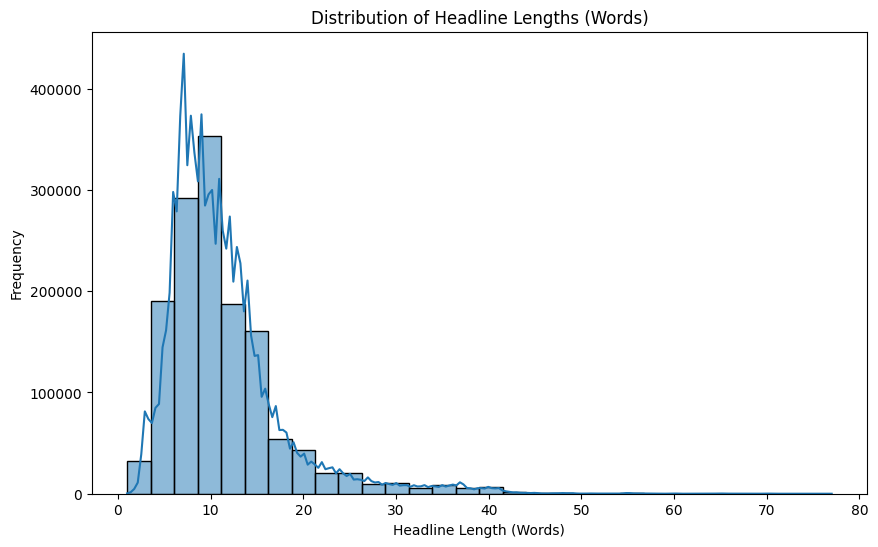

In [59]:
# Visualize headline length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths (Words)')
plt.xlabel('Headline Length (Words)')
plt.ylabel('Frequency')
plt.show()

In [60]:
# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
# Top publishers
top_publishers = publisher_counts.head(20)
print(top_publishers)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


/tmp/ipykernel_21377/2973725411.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='viridis')


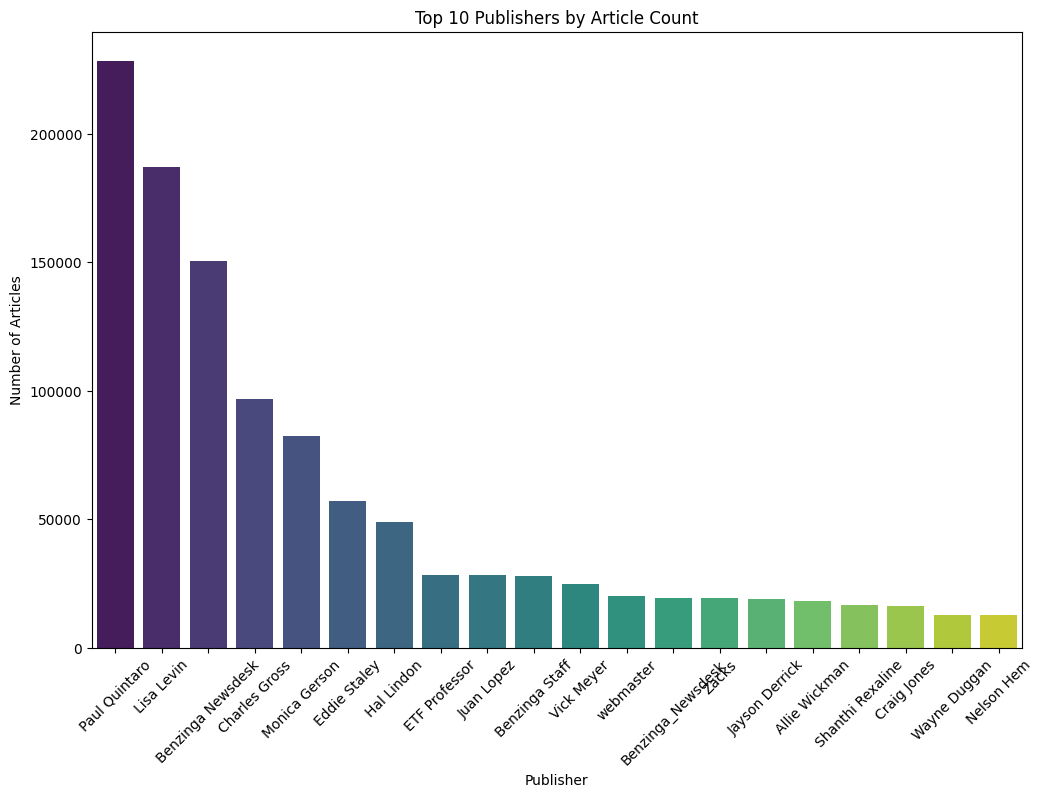

In [61]:
# Visualize the number of articles per top publisher
plt.figure(figsize=(12, 8))
sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='viridis')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

In [83]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], utc=True)

# Extract date parts
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()

df[['year', 'month', 'day']].head()

,year,month,day
0,2020,6,2
1,2020,5,31
2,2020,5,23
3,2020,5,19
4,2020,5,19


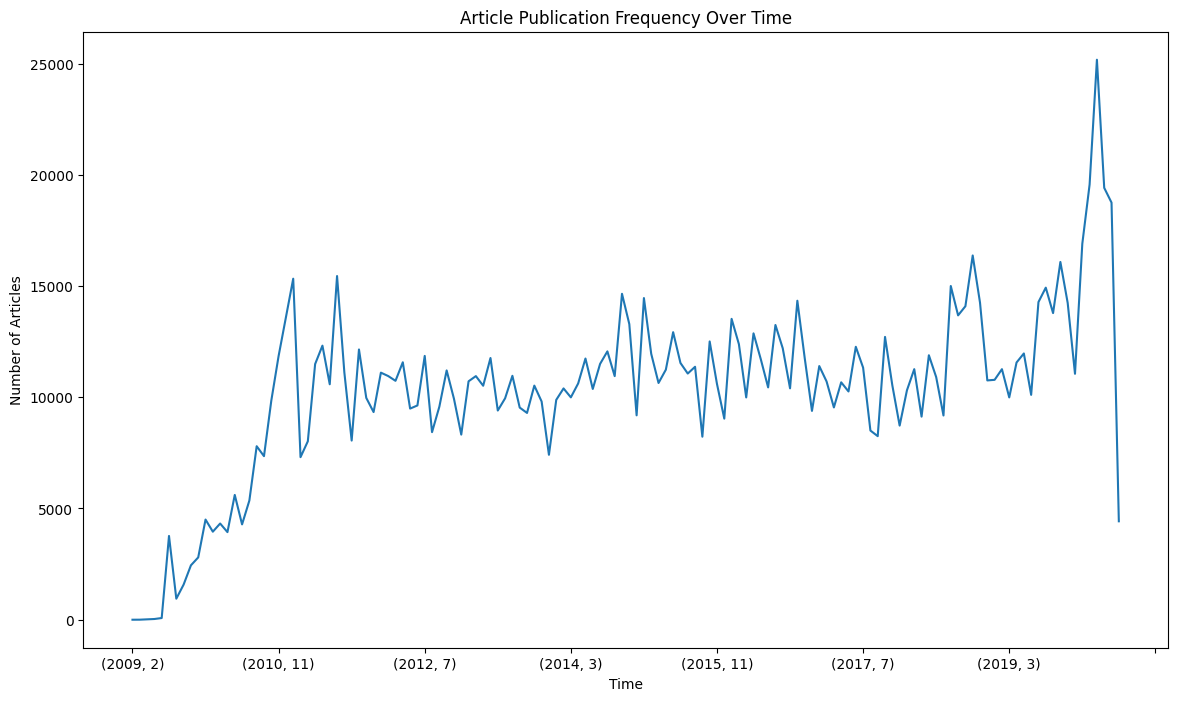

In [84]:
# Analyze the publication date trends
publication_trends = df.groupby(['year', 'month']).size()

# Visualize publication frequency over time
plt.figure(figsize=(14, 8))
publication_trends.plot(kind='line')
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Articles')
plt.show()